In [35]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix, accuracy_score, matthews_corrcoef, f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline


In [36]:
%pwd


'D:\\Python\\DataScience\\DataScience6105\\Module3'

In [37]:
my_path = 'D:\\Python\\DataScience\\DataScience6105\\Module3'
print(my_path)


D:\Python\DataScience\DataScience6105\Module3


In [38]:
#my_df is a dataframe
my_df = pd.read_csv(f'{my_path}/Titanic_full.csv')
my_df.shape
#my_df.head(3)


(1309, 12)

In [39]:
def mydf_splitter(my_df, num_rows):
    return my_df[:num_rows].copy(), my_df[num_rows:]
mydf_train_valid, mydf_test = mydf_splitter(my_df, 1100)
print(mydf_train_valid.shape)
print(mydf_test.shape)


(1100, 12)
(209, 12)


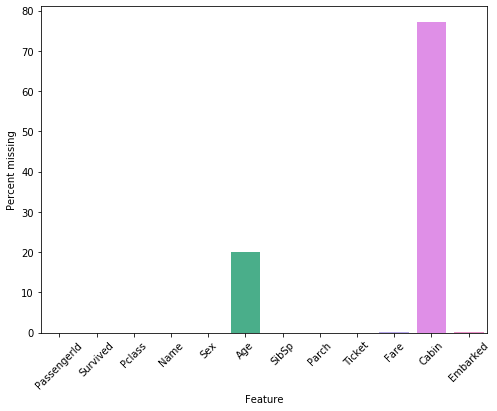

In [40]:
null_vals = mydf_train_valid.isnull().sum() / len(mydf_train_valid) * 100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation = 45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)


In [41]:
mydf_train_valid_2 = mydf_train_valid.drop('Cabin', axis = 1)
print(mydf_train_valid_2.shape)
#mydf_train_valid.info
mydf_train_valid_2.head(2)


(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [42]:
mydf_train_valid_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null object
Sex            1100 non-null object
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null object
Fare           1099 non-null float64
Embarked       1098 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 94.6+ KB


In [43]:
def str_to_cat(my_df):
    for p, q in my_df.items():
        if is_string_dtype(q):
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
mydf_train_valid_3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null category
Sex            1100 non-null category
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null category
Fare           1099 non-null float64
Embarked       1098 non-null category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [44]:
print(mydf_train_valid_3.Embarked.cat.categories)
print(mydf_train_valid_3.Sex.cat.categories)



Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [45]:
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)
mydf_train_valid_4.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False


In [47]:
print(my_table)
print(mydf_train_valid_4.shape)


{'Age': 28.0, 'Fare': 14.4583}
(1100, 13)


In [49]:
Y = mydf_train_valid_4['Survived']
X = mydf_train_valid_4.drop(['Survived'], axis = 1)
print(X.shape, Y.shape)
print(X.info())


(1100, 12) (1100,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 12 columns):
PassengerId    1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null int16
Sex            1100 non-null int8
Age            1100 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null int16
Fare           1100 non-null float64
Embarked       1100 non-null int8
Age_na         1100 non-null bool
Fare_na        1100 non-null bool
dtypes: bool(2), float64(2), int16(2), int64(4), int8(2)
memory usage: 60.2 KB
None


In [50]:
X_con = X[['Age', 'Fare']]
X_cat = X.drop(X_con, axis = 1)
print(X_cat.shape, X_con.shape)


(1100, 10) (1100, 2)


In [51]:
scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ['Age', 'Fare']
print(X_con_sc.shape)
X_con_sc.head(2)


(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [52]:
df_list = [X_cat, X_con_sc]
X_full = pd.concat(df_list, axis = 1)
X_full.head(2)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [53]:
X_train, X_valid = mydf_splitter(X_full, 900)
Y_train, Y_valid = mydf_splitter(Y, 900)


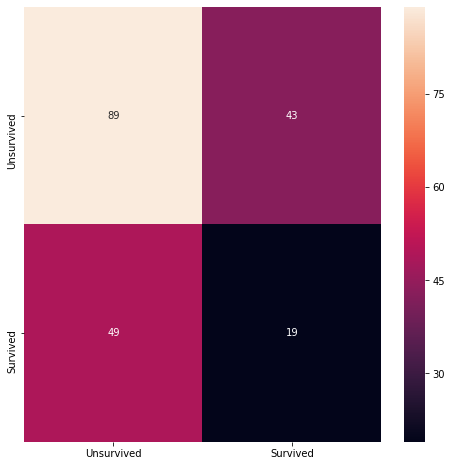

In [54]:
my_knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
my_knn_model.fit(X_train, Y_train)
Y_pred = my_knn_model.predict(X_valid)

my_knn_cmatrix = confusion_matrix(Y_valid, Y_pred)
my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize=(8,8))
sns.heatmap(my_knn_df, xticklabels=['Unsurvived', 'Survived'], yticklabels=['Unsurvived', 'Survived'], annot=True)


In [55]:
print(accuracy_score(Y_valid, Y_pred), matthews_corrcoef(Y_valid, Y_pred), f1_score(Y_valid, Y_pred))


0.54 -0.0474697036788388 0.29230769230769227


In [56]:
num_neighs = list()
accuracy_list = list()

for neighbor in range(1, 20):
    my_knn_model = KNeighborsClassifier(n_neighbors=neighbor, weights='uniform')
    my_knn_model.fit(X_train, Y_train)
    Y_pred = my_knn_model.predict(X_valid)
    accuracy = accuracy_score(Y_valid, Y_pred)
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)

eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list})
print(eval_df)


    Num of neighbors  Valid accuracy Score
0                  1                 0.500
1                  2                 0.580
2                  3                 0.495
3                  4                 0.565
4                  5                 0.540
5                  6                 0.560
6                  7                 0.530
7                  8                 0.570
8                  9                 0.555
9                 10                 0.595
10                11                 0.575
11                12                 0.575
12                13                 0.565
13                14                 0.600
14                15                 0.580
15                16                 0.590
16                17                 0.560
17                18                 0.580
18                19                 0.570


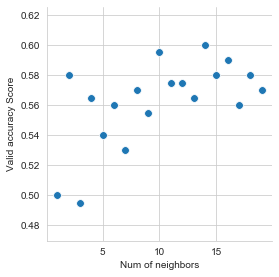

In [63]:
sns.set_style('whitegrid')
sns.pairplot(eval_df, x_vars='Num of neighbors', y_vars='Valid accuracy Score', plot_kws={'s': 60}, height = 4.0)


In [64]:
knn_model_fin = KNeighborsClassifier(n_neighbors=14, weights='uniform')
knn_model_fin.fit(X_full, Y)

!mkdir knn_model
knn_model_name = f'{my_path}/knn_model/knn_model_final.sav'
joblib.dump(knn_model_fin, knn_model_name)


['D:\\Python\\DataScience\\DataScience6105\\Module3/knn_model/knn_model_final.sav']

In [66]:
knn_model_loaded = joblib.load(knn_model_name)


In [ ]:
mydf_test1 = mydf_test.drop('Cabin', axis=1)
print(mydf_test1.shape)
mydf_test2 = str_to_cat(mydf_test1)
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,null_table = my_table)
print(mydf_test3.shape)
Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)

X_con_t = X_t[['Age', 'Fare']]
X_cat_t = X_t.drop(X_con_t, axis = 1)

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]

